# Purpose

To assess differences between urban representation experiments.

In [17]:
__version__ = "2025-02-12"
__author__ = "Mathew Lipson"
__email__ = "m.lipson@unsw.edu.au"

import xarray as xr
import iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import importlib

from dask.distributed import Client

oshome = os.getenv('HOME')
sys.path.append(f'{oshome}/git/RNS_Sydney_1km/plotting_code')
import common_functions as cf
importlib.reload(cf)

datapath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf'
plotpath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/figures'
stationpath = '/g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min'
cylc_id = 'rns_ostia'
cycle_path = f'/scratch/ce10/mjl561/cylc-run/{cylc_id}/share/cycle'

local_time = True
local_time_offset = 10

available_variables = [
    'land_sea_mask', 'air_temperature', 'surface_temperature', 'relative_humidity',
    'latent_heat_flux', 'sensible_heat_flux', 'air_pressure_at_sea_level',
    'dew_point_temperature', 'surface_net_downward_longwave_flux', 'wind_u', 'wind_v',
    'specific_humidity', 'specific_humidity_lowest_atmos_level', 'wind_speed_of_gust',
    'soil_moisture_l1', 'soil_moisture_l2', 'soil_moisture_l3', 'soil_moisture_l4',
    'soil_temperature_l1', 'soil_temperature_l2', 'soil_temperature_l3', 'soil_temperature_l4',
    'surface_runoff_flux', 'subsurface_runoff_flux', 'surface_total_moisture_flux',
    'boundary_layer_thickness', 'surface_air_pressure',
    'fog_area_fraction', 'visibility', 'cloud_area_fraction',
    'stratiform_rainfall_amount', 'stratiform_rainfall_flux',
    'toa_outgoing_shortwave_flux', 'toa_outgoing_shortwave_flux_corrected', 'toa_outgoing_longwave_flux',
    'surface_net_longwave_flux',
]

try:
    print(client)
except Exception:
    client = Client()
client

<Client: 'tcp://127.0.0.1:37915' processes=7 threads=14, memory=125.19 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39119/status,
Dashboard: http://127.0.0.1:39119/status,Workers: 7
Total threads: 14,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37915,Workers: 7
Dashboard: http://127.0.0.1:39119/status,Total threads: 14
Started: 12 minutes ago,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39793,Total threads: 2
Dashboard: http://127.0.0.1:44747/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:35707,


## Local functions

Local functions for this notebook are below. Much of this code draws on common_functions.py

In [35]:

def create_spatial_timeseries_plot(ds, exps, suffix='', itime=0,  masked=False, distance=100):

    lsm_opts = cf.get_variable_opts('land_sea_mask')
    lsm_ds = cf.open_output_netcdf([exps[0]], lsm_opts, 'land_sea_mask', datapath)

    if masked:
        ds_masked = ds.where(lsm_ds[exps[0]].isel(time=0)==1)
    else:
        ds_masked = ds.copy()
    if itime is not None:
        dss_masked = ds_masked.isel(time=itime)
    else:
        dss_masked = ds_masked.copy()

    fig, fname = cf.plot_spatial(exps, dss_masked, vopts, [], stations, obs, slabels=False, fill_size=10,
        fill_obs=False, ncols=len(exps), distance=distance, suffix=suffix)

    # create new ax on the bottom of the current axes
    axins = fig.add_axes([0.08, -0.4, 0.83, 0.3])
    axins.set_title(f'Domain averaged {opts["plot_title"]}')
    
    # calculate the spatially averaged timeseries for each experiment
    ts = ds_masked.mean(dim=['latitude','longitude'])
    ts = ts.to_dataframe()[exps]
    # if ts has multiindex, drop the second index
    if isinstance(ts.index, pd.MultiIndex):
        ts.index = ts.index.droplevel(1)

    # plot the timeseries
    ts_plot = ts.plot(ax=axins)
    
    # update axins legend
    axins.legend([exp_plot_titles[exp] for exp in exps], loc='upper right', fontsize=8, bbox_to_anchor=(1.0,-0.2))

    # get xticks and labels
    xticks = axins.get_xticks()

    if itime is not None:
        for i,exp in enumerate(exps):
            # get colour from ts_plot
            exp_col = ts_plot.get_lines()[i].get_color()
            # add point for current time on timeseries for each experiment
            axins.scatter(ts.index[itime], ts.iloc[itime][exp], color=exp_col, s=20, clip_on=False)

    return fig, fname

def create_spatial_timeseries_plot_vs_obs(exps, ds, vopts, sids, stations, obs, 
                                          itime=0, masked=False, distance=100, suffix=''):

    lsm_opts = cf.get_variable_opts('land_sea_mask')
    lsm_ds = cf.open_output_netcdf([exps[0]], lsm_opts, 'land_sea_mask', datapath)

    # ensure obs match passed ds in time and space
    # select only obs that align with ds model times
    if not obs.empty:
        obs = obs.loc[ds.time.values]

    # trim sids to those in ds
    sids_to_pass = cf.trim_sids(ds, obs, sids, stations)

    # get masked data
    if masked:
        ds_masked = ds.where(lsm_ds[exps[0]].isel(time=0)==1)
    else:
        ds_masked = ds.copy()
    if itime is not None:
        dss_masked = ds_masked.isel(time=itime)
    else:
        dss_masked = ds_masked.copy()
    # dss_masked['time'] = time

    ########## plot ##########

    fig, fname = cf.plot_spatial(exps, dss_masked, vopts, sids_to_pass, stations, obs, slabels=True, fill_size=10,
        fill_obs=True, ncols=len(exps), distance=distance, suffix=suffix)

    fname = fname.split('.png')[0] + '_vs_obs.png'

    # create new ax on the bottom of the current axes
    axins = fig.add_axes([0.08, -0.4, 0.83, 0.3])
    axins.set_title(f'Site averaged {opts["plot_title"]}: {len(sids_to_pass)} sites')

    # calculate the site location averaged timeseries for each experiment

    sim_site_list = []
    for sid in sids_to_pass:
        lat = stations.loc[sid,'lat']
        lon = stations.loc[sid,'lon']
        sim_site = ds_masked.sel(latitude=lat,longitude=lon, method='nearest').to_dataframe()[exps]
        sim_site_list.append(sim_site)
    # combine sim_site_list and calculate average for each experiment
    sim_ts = pd.concat(sim_site_list).groupby(level=0).mean()

    # plot the timeseries
    ts_plot = sim_ts.plot(ax=axins)
    axins.set_ylabel(opts['units'])

    # now plot the site observation average
    obs_ts = obs[sids_to_pass].mean(axis=1)
    obs_ts.name = 'observations'
    obs_ts.plot(ax=axins, color='black', linestyle='--', label='observations')

    if itime is not None:
        for i,exp in enumerate(exps):
            # get colour from ts_plot
            exp_col = ts_plot.get_lines()[i].get_color()
            # add point for current time on timeseries for each experiment
            axins.scatter(sim_ts.index[itime], sim_ts.iloc[itime][exp], color=exp_col, s=20, clip_on=False)
            # add point for observations
            axins.scatter(sim_ts.index[itime], obs_ts.iloc[itime], color='black', s=20, clip_on=False)

    # get legend handles and labels
    handles, labels = axins.get_legend_handles_labels()
    # add MAE and BIAS to labels in exp
    for exp in exps:
        mae = cf.calc_MAE(sim_ts[exp], obs_ts)
        mbe = cf.calc_MBE(sim_ts[exp], obs_ts)
        labels[exps.index(exp)] = f'{exp_plot_titles[exp]}    MAE: {mae:.2f}, MBE: {mbe:.2f}]'
    axins.legend(handles, labels, loc='upper right', fontsize=8, bbox_to_anchor=(1.0,-0.2))

    #### diurnal plot ####
    if itime is None:
        df = pd.concat([sim_ts, obs_ts], axis=1)
        df_diurnal = df.groupby(df.index.hour).mean()
        # plot with observations column in black
        df_diurnal.plot(color=[exp_colours[exp] for exp in exps]+['black'])
        plt.title(f'Diurnally averaged {opts["plot_title"]}: {len(sids_to_pass)} sites')

    return fig, fname

def set_up_plot_attrs(exps, plotpath):

    # predefine colours for experiments
    exp_colours = {
        'E5L_11p1_CCI'    : 'tab:blue',
        'BR2_12p2_CCI'    : 'tab:orange',
        'BARRA-C2'        : 'tab:green',
        'BARRA-R2'        : 'green',
        'ACCESS-G'        : 'grey',
        }

    exp_plot_titles = {
        'ACCESS-G'       : 'ACCESS-G3 Global',
        'E5L_11p1_CCI'   : 'ERA5-Land 11.1km (CCI)',
        'E5L_5_CCI'      : 'ERA5-Land 5km (CCI)',
        'E5L_1_CCI'      : 'ERA5-Land 1km (CCI)',
        'E5L_1_L_CCI'    : 'ERA5-Land 1km (CCI large domain)',

        'BR2_12p2_CCI'   : 'BARRA-R2 12.2km (CCI)',
        'BR2_5_CCI'      : 'BARRA-R2 5km (CCI)',
        'BR2_1_CCI'      : 'BARRA-R2 1km (CCI)',
        'BR2_1_L_CCI'    : 'BARRA-R2 1km (CCI large domain)',

        'BR2_5_CCI_WC'   : 'BARRA-R2 5km (CCI+WorldCover)',
        'BR2_1_CCI_WC'   : 'BARRA-R2 1km (CCI+WorldCover)',
        'BR2_1_L_CCI_WC' : 'BARRA-R2 1km (CCI+WorldCover large domain)',

        'BR2_5_IGBP'     : 'BARRA-R2 5km (IGBP)',
        'BR2_1_IGBP'     : 'BARRA-R2 1km (IGBP)',
        'BR2_1_L_IGBP'   : 'BARRA-R2 1km (IGBP large domain)',

        'BR2_5_CCI_no_urban' : 'BARRA-R2 5km (CCI no urban)',
        'BR2_1_CCI_no_urban' : 'BARRA-R2 1km (CCI no urban)',
        'BR2_1_L_CCI_no_urban' : 'BARRA-R2 1km (CCI no urban large domain)',

        'BARRA-R2'       : 'BARRA-R2 12.2km (reanalysis product)',
        'BARRA-C2'       : 'BARRA-C2 4.4km (reanalysis product)',

        }

    # drop keys not in exps
    exp_colours = {key: exp_colours[key] for key in exp_colours if key in exps}
    exp_plot_titles = {key: exp_plot_titles[key] for key in exp_plot_titles if key in exps}
    
    # create entry in exp_plot_titles if key not in exps
    extra_colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'][::-1]
    for exp in exps:
        if exp not in exp_colours:
            colour = extra_colours.pop()
            while colour in list(exp_colours.values()):
                colour = extra_colours.pop()
            exp_colours[exp] = colour

        if exp not in exp_plot_titles:
            exp_plot_titles[exp] = exp
    
    cf.local_time = local_time
    cf.plotpath = plotpath
    cf.exp_colours = exp_colours
    cf.exp_plot_titles = exp_plot_titles

    return exp_colours, exp_plot_titles

### Air temperature

In [19]:
variable = 'air_temperature'
exps = [
        ### Parent models ###
        # 'E5L_11p1_CCI',
        # 'BR2_12p2_CCI',
        # ## ERA5-Land CCI ###
        # 'E5L_5_CCI',
        # 'E5L_1_CCI',
        # 'E5L_1_L_CCI',
        # ### ERA5-Land CCI WordCover ###
        # 'E5L_5_CCI_WC',
        # 'E5L_1_CCI_WC',
        # 'E5L_1_L_CCI_WC',
        # ### BARRA CCI ###
        # 'BR2_5_CCI',
        # 'BR2_1_CCI',
        'BR2_1_L_CCI',
        # ### BARRA CCI WorldCover ###
        # 'BR2_5_CCI_WC',
        # 'BR2_1_CCI_WC',
        'BR2_1_L_CCI_WC',
        # # ### BARRA IGBP ###
        # 'BR2_5_IGBP',
        # 'BR2_1_IGBP',
        'BR2_1_L_IGBP',
        # ### BARRA CCI no urban ###
        # 'BR2_5_CCI_no_urban',
        # 'BR2_1_CCI_no_urban',
        'BR2_1_L_CCI_no_urban',
        ### BARRA operational reanalysis ###
        # 'BARRA-R2',
        'BARRA-C2',
        ]

exp_colours, exp_plot_titles = set_up_plot_attrs(exps, plotpath)

# check if plotpath exists, make if necessary
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

print(f'processing {variable}')

opts = cf.get_variable_opts(variable)
ds = cf.open_output_netcdf(exps,opts,variable,datapath)

# convert to local time and update timezone
if local_time and ds.time.attrs['timezone'] == 'UTC': 
    print('updating from UTC to local time')
    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

ds = ds.compute()

ds


processing air_temperature
attempting to open 5 experiments:
['BR2_1_L_CCI', 'BR2_1_L_CCI_WC', 'BR2_1_L_IGBP', 'BR2_1_L_CCI_no_urban', 'BARRA-C2']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BR2_1_L_CCI_air_temperature_1p5m.nc
  opening air_temperature BR2_1_L_CCI
2: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BR2_1_L_CCI_WC_air_temperature_1p5m.nc
  opening air_temperature BR2_1_L_CCI_WC
3: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BR2_1_L_IGBP_air_temperature_1p5m.nc
  opening air_temperature BR2_1_L_IGBP
4: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BR2_1_L_CCI_no_urban_air_temperature_1p5m.nc
  opening air_temperature BR2_1_L_CCI_no_urban
5: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/air_temperature_1p5m/BARRA-C2_air_temperature_1p5m.nc
loading BARRA-C2
updating from UTC to 

<xarray.Dataset> Size: 11GB
Dimensions:               (latitude: 720, longitude: 960, time: 672)
Coordinates:
  * latitude              (latitude) float32 3kB -37.14 -37.13 ... -30.67 -30.67
  * longitude             (longitude) float32 4kB 146.9 146.9 ... 155.5 155.5
    height                float64 8B 1.5
    crs                   int32 4B 0
  * time                  (time) datetime64[ns] 5kB 2017-01-01T11:00:00 ... 2...
Data variables:
    BR2_1_L_CCI           (time, latitude, longitude) float32 2GB 22.76 ... 2...
    BR2_1_L_CCI_WC        (time, latitude, longitude) float32 2GB 22.71 ... 2...
    BR2_1_L_IGBP          (time, latitude, longitude) float32 2GB 22.66 ... 2...
    BR2_1_L_CCI_no_urban  (time, latitude, longitude) float32 2GB 22.71 ... 2...
    BARRA-C2              (time, latitude, longitude) float64 4GB 22.57 ... 2...

### Get obs data

In [22]:
variable = 'air_temperature'
if variable in ['sensible_heat_flux','latent_heat_flux','soil_moisture_l1','soil_moisture_l2','soil_moisture_l3']:
    # print('getting flux obs')
    obs, stations = cf.get_flux_obs(variable, local_time_offset=None)
    print('no obs available')
elif variable in ['air_temperature','dew_point_temperature']:
    obs, stations = cf.process_station_netcdf(variable, stationpath, local_time_offset=local_time_offset)
else:
    print('no obs available')
    # set up dummy obs and stations dataframes
    obs, stations = pd.DataFrame(), pd.DataFrame()
    sids, sufix = [], ''

# convert to local time if obs is not None
if local_time and not obs.empty:
    obs.index = obs.index + pd.Timedelta(f'{local_time_offset}h')

# trim obs dataframe to ds time period
obs = obs.loc[ds.time.min().values:ds.time.max().values]

# select only obs that align with ds model times
if not obs.empty:
    obs = obs.loc[ds.time.values]

# select all stations
sids, suffix = stations.index.tolist(), '_all'

# trim sids to those in ds
sids, suffix = cf.trim_sids(ds, obs, sids, stations), '_trimmed'

lsm_opts = cf.get_variable_opts('land_sea_mask')
lsm_ds = cf.open_output_netcdf([exps[0]], lsm_opts, 'land_sea_mask', datapath)

# only pass obs if their lat/lon is within the lsm mask
sids_to_pass = []
for sid in sids:
    lat = stations.loc[sid,'lat']
    lon = stations.loc[sid,'lon']
    if lsm_ds[exps[0]].isel(time=0).sel(latitude=lat,longitude=lon, method = 'nearest')==1:
        sids_to_pass.append(sid)

stations.loc[sids_to_pass]

opening /g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min/all_stations_air_temperature_from_2013-01-01.nc
attempting to open 1 experiments:
['BR2_1_L_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/BR2_1_L_CCI_land_sea_mask.nc
  opening land_sea_mask BR2_1_L_CCI


,lat,lon,elevation,state,name
72161,-35.9371,148.3779,1482.4,NSW,CABRAMURRA SMHEA AWS
67105,-33.6004,150.7761,19.0,NSW,RICHMOND RAAF
61260,-32.7914,151.3369,66.5,NSW,CESSNOCK AIRPORT AWS
51161,-30.9776,148.3798,181.3,NSW,COONAMBLE AIRPORT AWS
67119,-33.8510,150.8567,100.0,NSW,HORSLEY PARK EQUESTRIAN CENTRE AWS
...,...,...,...,...,...
72160,-36.0690,146.9509,163.5,NSW,ALBURY AIRPORT AWS
68072,-34.9469,150.5353,109.0,NSW,NOWRA RAN AIR STATION AWS
61250,-32.6296,151.5919,30.0,NSW,PATERSON (TOCAL AWS)
70351,-35.3106,149.1970,577.1,NSW,CANBERRA AIRPORT


### Sydney

Temperature analaysis: full period

attempting to open 1 experiments:
['BR2_1_L_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/BR2_1_L_CCI_land_sea_mask.nc
  opening land_sea_mask BR2_1_L_CCI
dss includes time period
calculating mean between 2017-01-01 11:00 and 2017-01-29 10:00
plotting air_temperature 2017-01-01 11:00 - 2017-01-29 10:00
BR2_1_L_CCI
BR2_1_L_CCI_WC
BR2_1_L_IGBP
BR2_1_L_CCI_no_urban
BARRA-C2
fname: air_temperature_1p5m_spatial_2017-01-01_1100_to_2017-01-29_1000_AEST_1km_SY_comparison.png


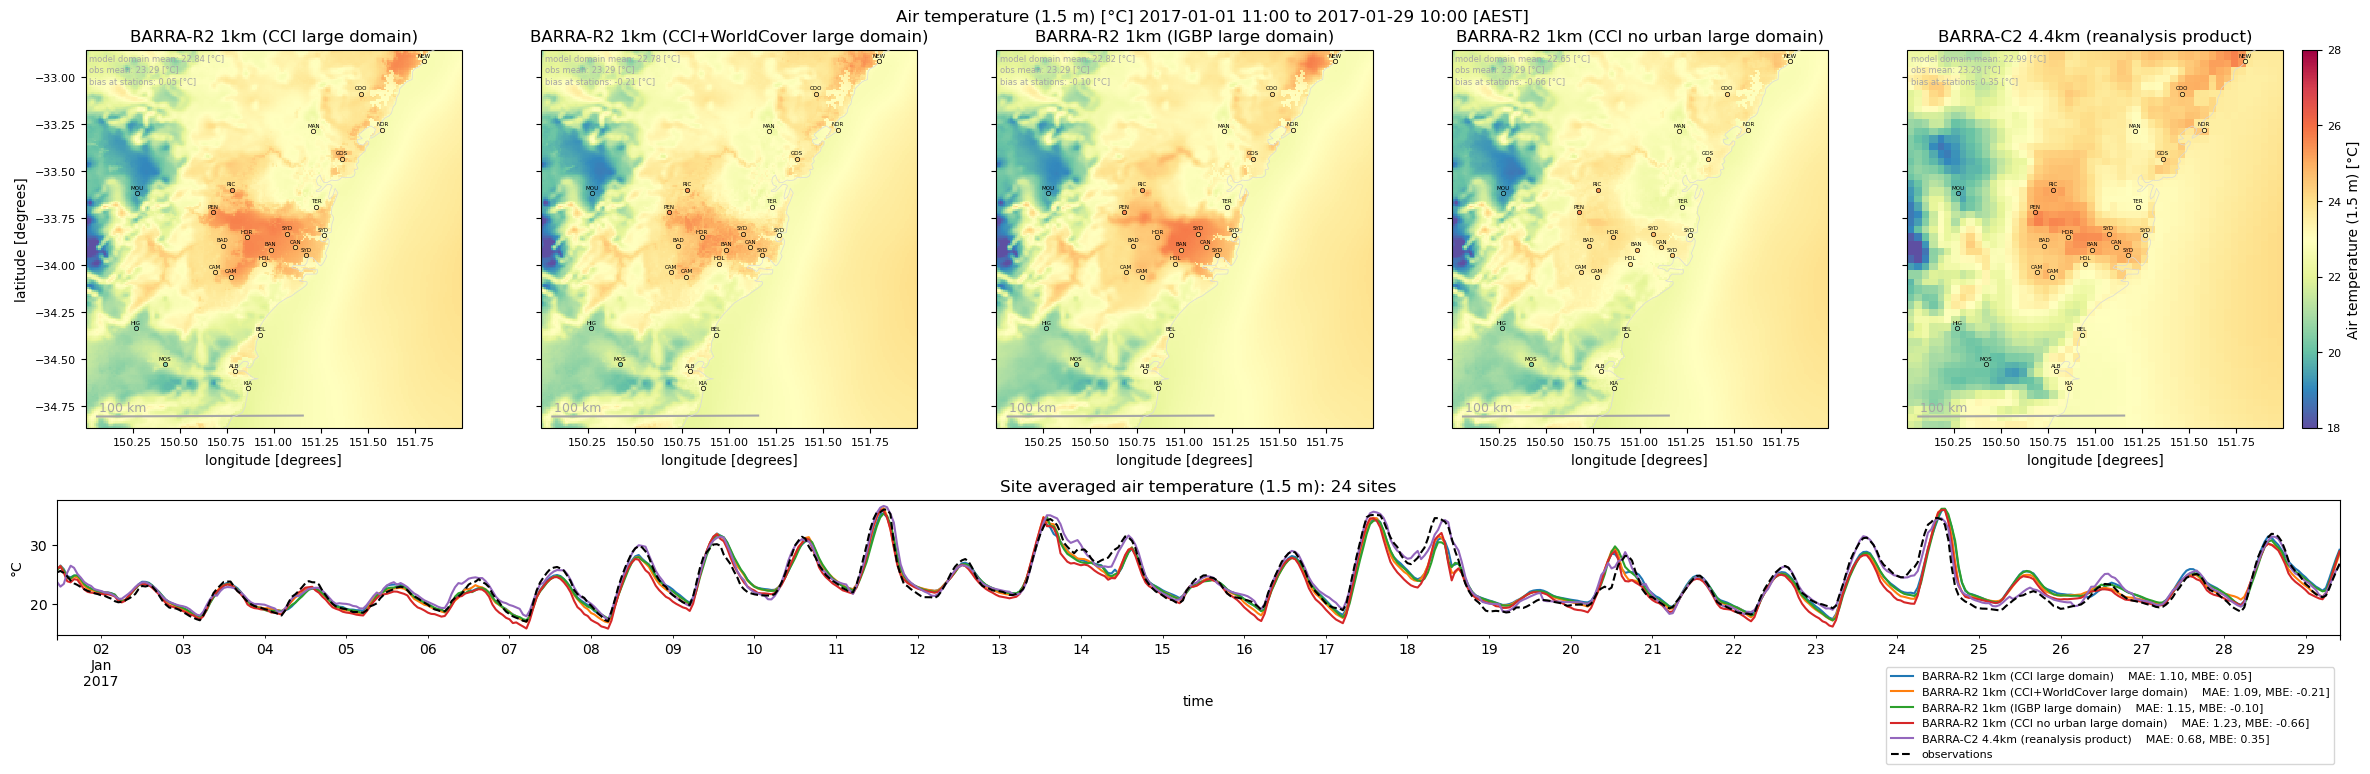

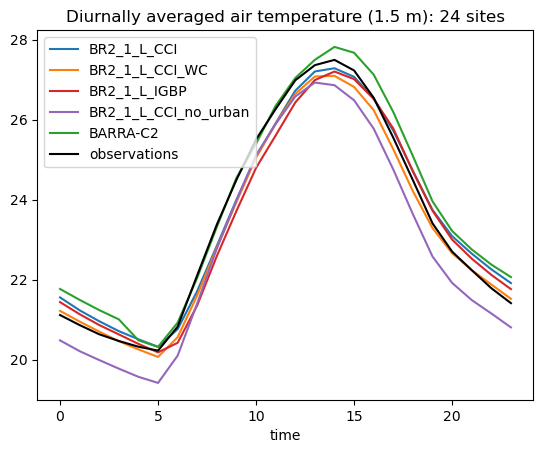

In [36]:
# Sydney lat/lon
lat, lon = -33.86, 151.0
# sel box around canberra
dss = ds.sel(latitude=slice(lat-1,lat+1),longitude=slice(lon-1,lon+1))
vopts = cf.update_opts(opts,
    vmin=18,
    vmax=28,
    cmap='Spectral_r'
    )

sids, suffix = cf.trim_sids(dss, obs, sids, stations), '_trimmed'
fig, fname = create_spatial_timeseries_plot_vs_obs(exps, dss, vopts, sids, stations, obs, 
                                          itime=None, masked=False, distance=100, suffix='_1km_SY_comparison')

Partial timeseries analysis using Sydney locations

In [44]:
# Sydney lat/lon
lat, lon = -33.86, 151.0
# sel box around canberra
dss = ds.sel(latitude=slice(lat-1,lat+1),longitude=slice(lon-1,lon+1)).sel(time=slice('2017-01-08','2017-01-18'))
vopts = cf.update_opts(opts,
    vmin=18,
    vmax=28,
    cmap='Spectral_r'
    )

sydney_sids = ['67105','67119','66212','66194','68192','67113','68257','67108','66161','66037','66137']
stations.loc[sydney_sids]

,lat,lon,elevation,state,name
67105,-33.6004,150.7761,19.0,NSW,RICHMOND RAAF
67119,-33.8510,150.8567,100.0,NSW,HORSLEY PARK EQUESTRIAN CENTRE AWS
66212,-33.8338,151.0718,4.0,NSW,SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE)
66194,-33.9057,151.1134,3.0,NSW,CANTERBURY RACECOURSE AWS
68192,-34.0390,150.6890,73.9,NSW,CAMDEN AIRPORT AWS
67113,-33.7195,150.6783,24.7,NSW,PENRITH LAKES AWS
68257,-34.0615,150.7735,112.0,NSW,CAMPBELLTOWN (MOUNT ANNAN)
67108,-33.8969,150.7281,81.2,NSW,BADGERYS CREEK AWS
66161,-33.9925,150.9489,68.2,NSW,HOLSWORTHY AERODROME AWS
66037,-33.9465,151.1731,6.0,NSW,SYDNEY AIRPORT AMO


attempting to open 1 experiments:
['BR2_1_L_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/BR2_1_L_CCI_land_sea_mask.nc
  opening land_sea_mask BR2_1_L_CCI
dss includes time period
calculating mean between 2017-01-08 00:00 and 2017-01-18 23:00
plotting air_temperature 2017-01-08 00:00 - 2017-01-18 23:00
BR2_1_L_CCI
BR2_1_L_CCI_WC
BR2_1_L_IGBP
BR2_1_L_CCI_no_urban
BARRA-C2
fname: air_temperature_1p5m_spatial_2017-01-08_0000_to_2017-01-18_2300_AEST_1km_SY_comparison.png


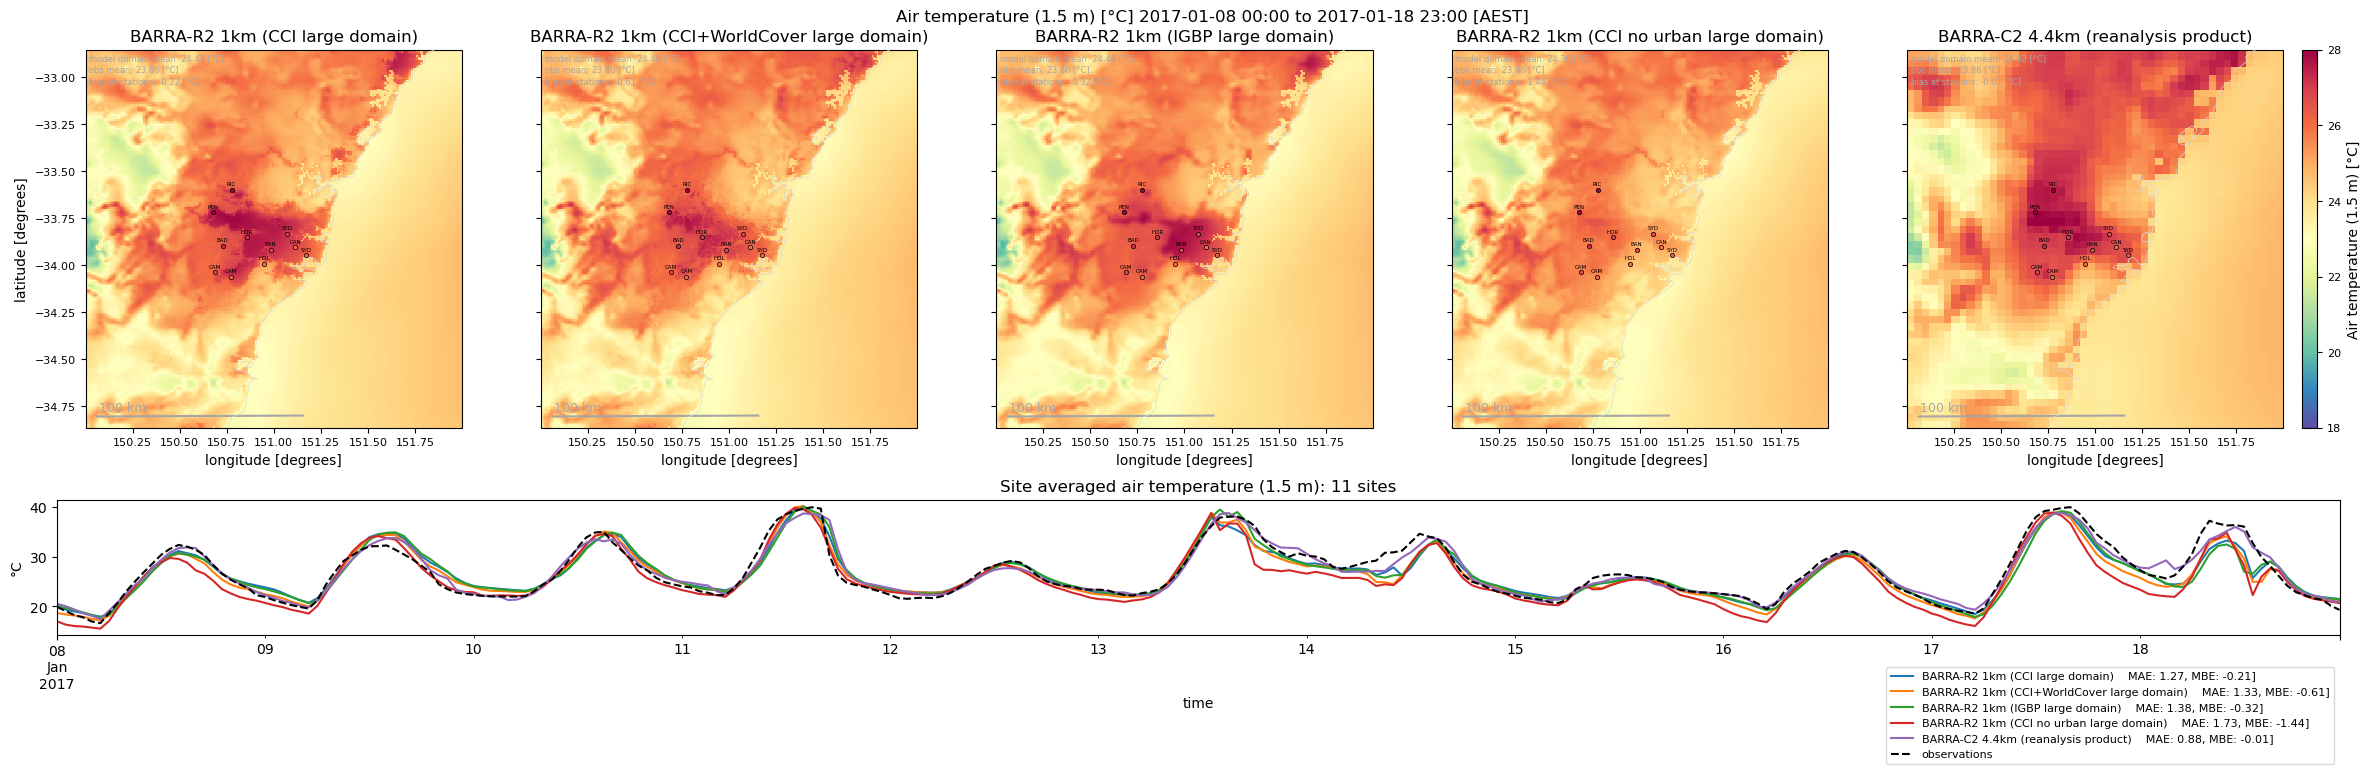

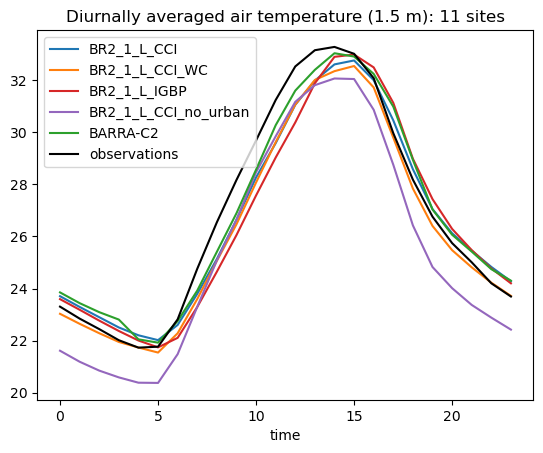

In [45]:
fig, fname = create_spatial_timeseries_plot_vs_obs(exps, dss, vopts, sydney_sids, stations, obs, 
                                          itime=None, masked=False, distance=100, suffix='_1km_SY_comparison')

attempting to open 1 experiments:
['BR2_1_L_CCI']
1: checking /g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf/land_sea_mask/BR2_1_L_CCI_land_sea_mask.nc
  opening land_sea_mask BR2_1_L_CCI
dss includes time period
calculating mean between 2017-01-08 00:00 and 2017-01-18 23:00
plotting air_temperature 2017-01-08 00:00 - 2017-01-18 23:00
BR2_1_L_CCI
BR2_1_L_CCI_WC
BR2_1_L_IGBP
fname: air_temperature_1p5m_spatial_2017-01-08_0000_to_2017-01-18_2300_AEST_1km_diff.png


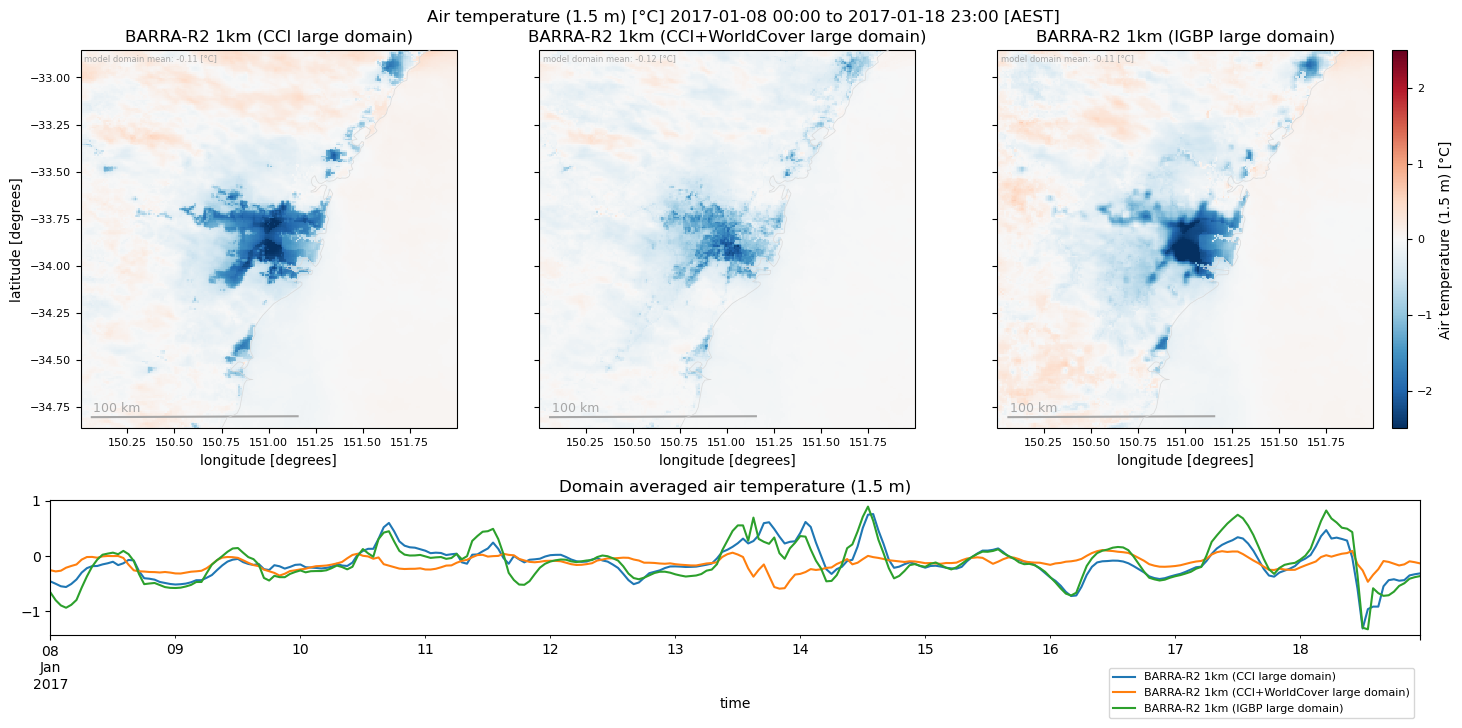

In [48]:
diff = dss['BR2_1_L_CCI_no_urban'] - dss
vopts = cf.update_opts(opts,
            vmin=-2.5,
            vmax=2.5,
            cmap='RdBu_r',
        )

fig, fname = create_spatial_timeseries_plot(diff, exps=exps[0:3],
                                            suffix='_1km_diff', itime=None, distance=100)